In [2]:
## Part 1: Wrangling
# Problem 1
import sqlite3
import pandas as pd
import numpy as np

from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Initiate db connection
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)
cursor = conn.cursor()

# Load Team_Data into DF
win_pct_formula = '((W + (CAST(G AS FLOAT(24)) - W - L)*0.5))*100/G'
team_data_query = 'SELECT yearID, teamID, lgID, franchID, G, W, L, {} as win_pct FROM Teams'.format(win_pct_formula)
team_data = pd.read_sql(team_data_query, conn)

# Load Salary data into DF
salary_query = 'SELECT yearID, teamID, sum(salary) as total_payroll FROM Salaries GROUP BY yearID, teamID'
team_salaries = pd.read_sql(salary_query, conn)

# Merge DFs
team_aggregate = team_data.merge(team_salaries, on=['yearID', 'teamID'])

# Insert aggregate table into db
team_aggregate.to_sql("TeamAggregate", conn, if_exists="replace")

#Describe how you dealt with any missing data in these two relations. Specifically, indicate if there is missing data in either table, and how the type of join you used determines how you dealt with this missing data. One note, for SQL you have to be mindful of integer vs. float division.
# After looking up how a team's win percentage is caluclate, I noticed that Ties was not included.  I reconsiled this missing variable by subtracting wins and losses from total games played.  I dealt with SQL's integer and float division by casting to prevent calculation issues.

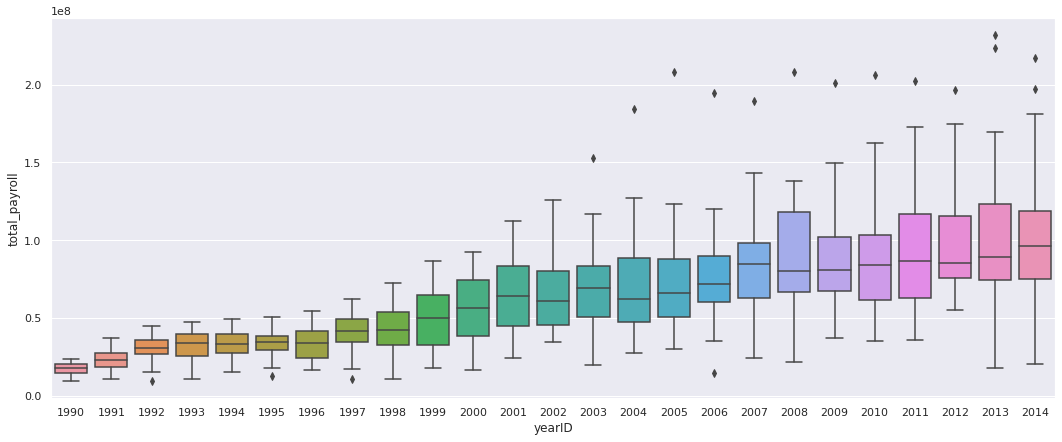

In [3]:
## Part 2: Exploratory Data Analysis
# Problem 2
import seaborn as sns
import matplotlib.pyplot as plt

begin_year = 1990
end_year = 2014
data_range_slice = team_aggregate[(team_aggregate.yearID >= begin_year) & (team_aggregate.yearID <= end_year)]

sns.set(rc={'figure.figsize':(18, 7)})
ax = sns.boxplot(x="yearID", y="total_payroll", data=data_range_slice)

In [4]:
## Part 2: Exploratory Data Analysis
# Question 1 - What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, etc.

#The distribution of payrolls overtime has grown increasingly disparate.  While the central tendancy has been growing slowly, the spread has been diverging rapidly.

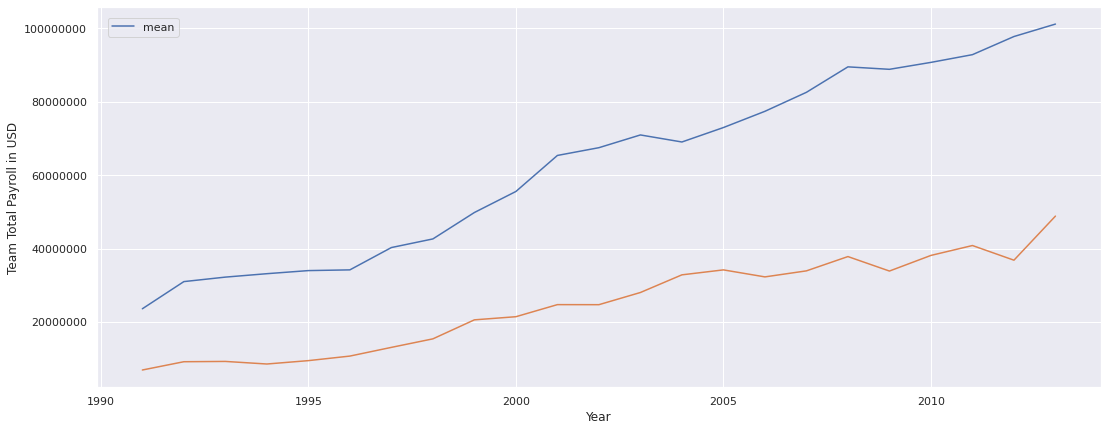

In [5]:
## Part 2: Exploratory Data Analysis
# Problem 3 - Write code to produce plots that specifically show at least one of the statements you made in Question 1. For example, if you make a statement that there is a trend for payrolls to decrease over time, make a plot of a statistic for central tendency (e.g., mean payroll) vs. time to show that specficially.

import matplotlib.pyplot as plt

# Initiate db connection
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

# Query db
data_query = 'SELECT yearID, teamID, total_payroll FROM TeamAggregate WHERE yearID > {0} AND yearID < {1}'.format(begin_year, end_year)
team_salaries = pd.read_sql(data_query, conn)
conn.close()

# Extract statistics, rename columns
year_stats = pd.DataFrame(team_salaries.groupby('yearID').describe())
year_stats.columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

# Plot
fig, ax = plt.subplots()
ax.ticklabel_format(useOffset=False, style='plain')
ax.set(xlabel='Year', ylabel='Team Total Payroll in USD')
plt.plot(year_stats['mean'].index, year_stats['mean'].values, label='mean')
plt.plot(year_stats['std'].index, year_stats['std'].values, label='std')
plt.legend(loc='upper left', borderaxespad=1)

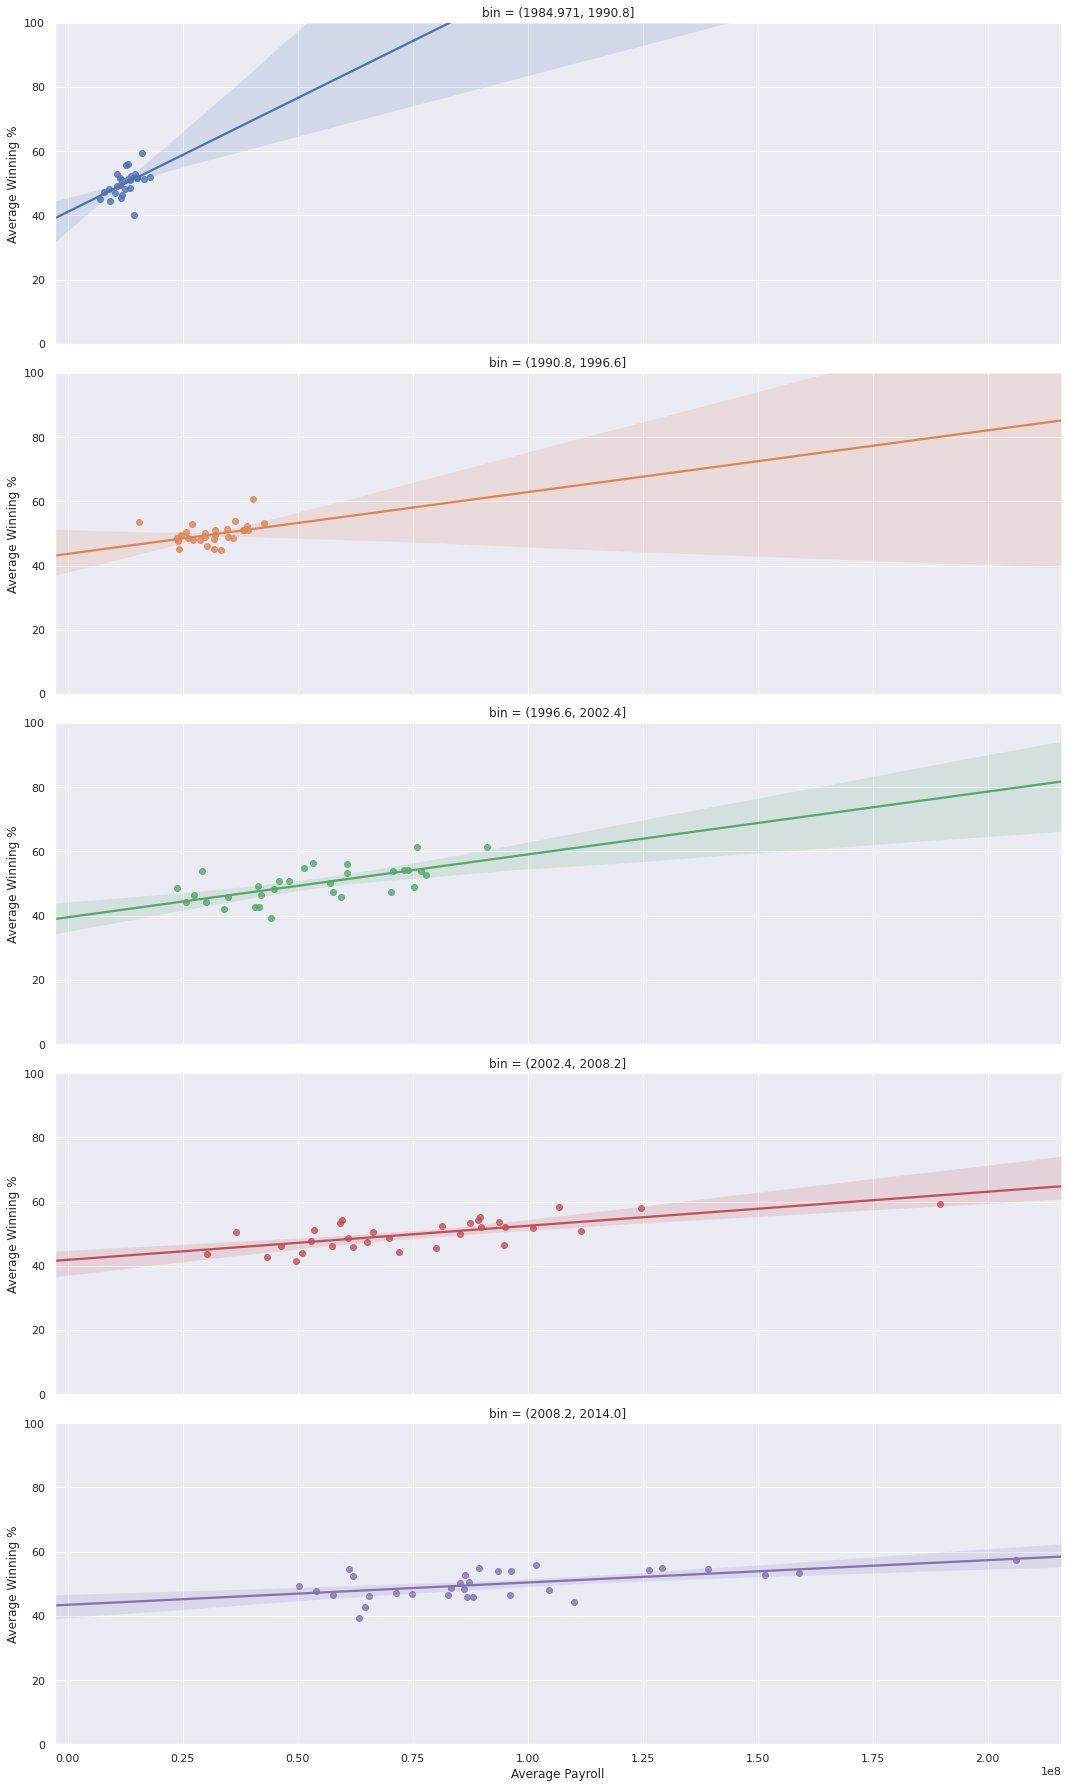

In [6]:
## Part 2: Exploratory Data Analysis
# Problem 4 - Write code to discretize year into five time periods (you can use pandas.cut to accomplish this) and then make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. You could add a regression line (using, e.g., NumPy's polyfit) in each scatter plot to ease interpretation.
import seaborn as sns

# Split into year bins
team_aggregate_1 = team_aggregate.copy()
team_aggregate_1['bin'] = pd.cut(team_aggregate_1['yearID'], bins=5)

# Create dataframes using List Comprehension which splits groups into list of dataframes 
year_group = pd.DataFrame(team_aggregate_1.groupby(['bin', 'teamID'])['total_payroll','win_pct'].mean().dropna()).reset_index()

# Plot
g = sns.lmplot(x='total_payroll', y='win_pct', col='bin', hue='bin', data=year_group, logistic=False, truncate=False, robust=True, aspect=3, col_wrap=1)
g.set_axis_labels("Average Payroll", "Average Winning %")
g.set(ylim=(0, 100))

In [7]:
## Part 2:
# Question 2 - What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A's spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).

# The payrolls across the periods have grown increasingly large in range, and the gain in winning percentage from increasing payroll has decreased.  You must increase player salaries more, for less winning gain.

In [8]:
## Part 3: Data transformations
# Standardizing across years - It looks like comparing payrolls across years is problematic so let's do a transformation that will help with these comparisons.

In [9]:
## Part 3
# Problem 5 - Create a new variable in your dataset that standardizes payroll conditioned on year.

# Calculate salary statistics
yearly_payroll_avg = team_aggregate.groupby(['yearID'])['total_payroll'].mean()
yearly_payroll_std = team_aggregate.groupby(['yearID'])['total_payroll'].std()

# Add standardized_payroll col to dataset
team_aggregate['standardized_payroll'] = team_aggregate.apply(lambda row: (row.total_payroll - yearly_payroll_avg.get(row.yearID)) / yearly_payroll_std.get(row.yearID), axis=1)

# Update data in db, for future
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)
team_aggregate.to_sql("TeamAggregate", conn, if_exists="replace")
conn.close()

# Display
team_aggregate.head(10)

,yearID,teamID,lgID,franchID,G,W,L,win_pct,total_payroll,standardized_payroll
0,1985,BAL,AL,BAL,161,83,78,51.552795,11560712.0,0.601068
1,1985,BOS,AL,BOS,163,81,81,50.000000,10897560.0,0.332678
2,1985,CAL,AL,ANA,162,90,72,55.555556,14427894.0,1.761474
3,1985,CHA,AL,CHW,163,85,77,52.453988,9846178.0,-0.092838
4,1985,CLE,AL,CLE,162,60,102,37.037037,6551666.0,-1.426192
5,1985,DET,AL,DET,161,84,77,52.173913,10348143.0,0.110318
6,1985,KCA,AL,KCR,162,91,71,56.172840,9321179.0,-0.305315
7,1985,MIN,AL,MIN,162,77,85,47.530864,5764821.0,-1.744643
8,1985,ML4,AL,MIL,161,71,90,44.099379,11284107.0,0.489121
9,1985,NYA,AL,NYY,161,97,64,60.248447,14238204.0,1.684702


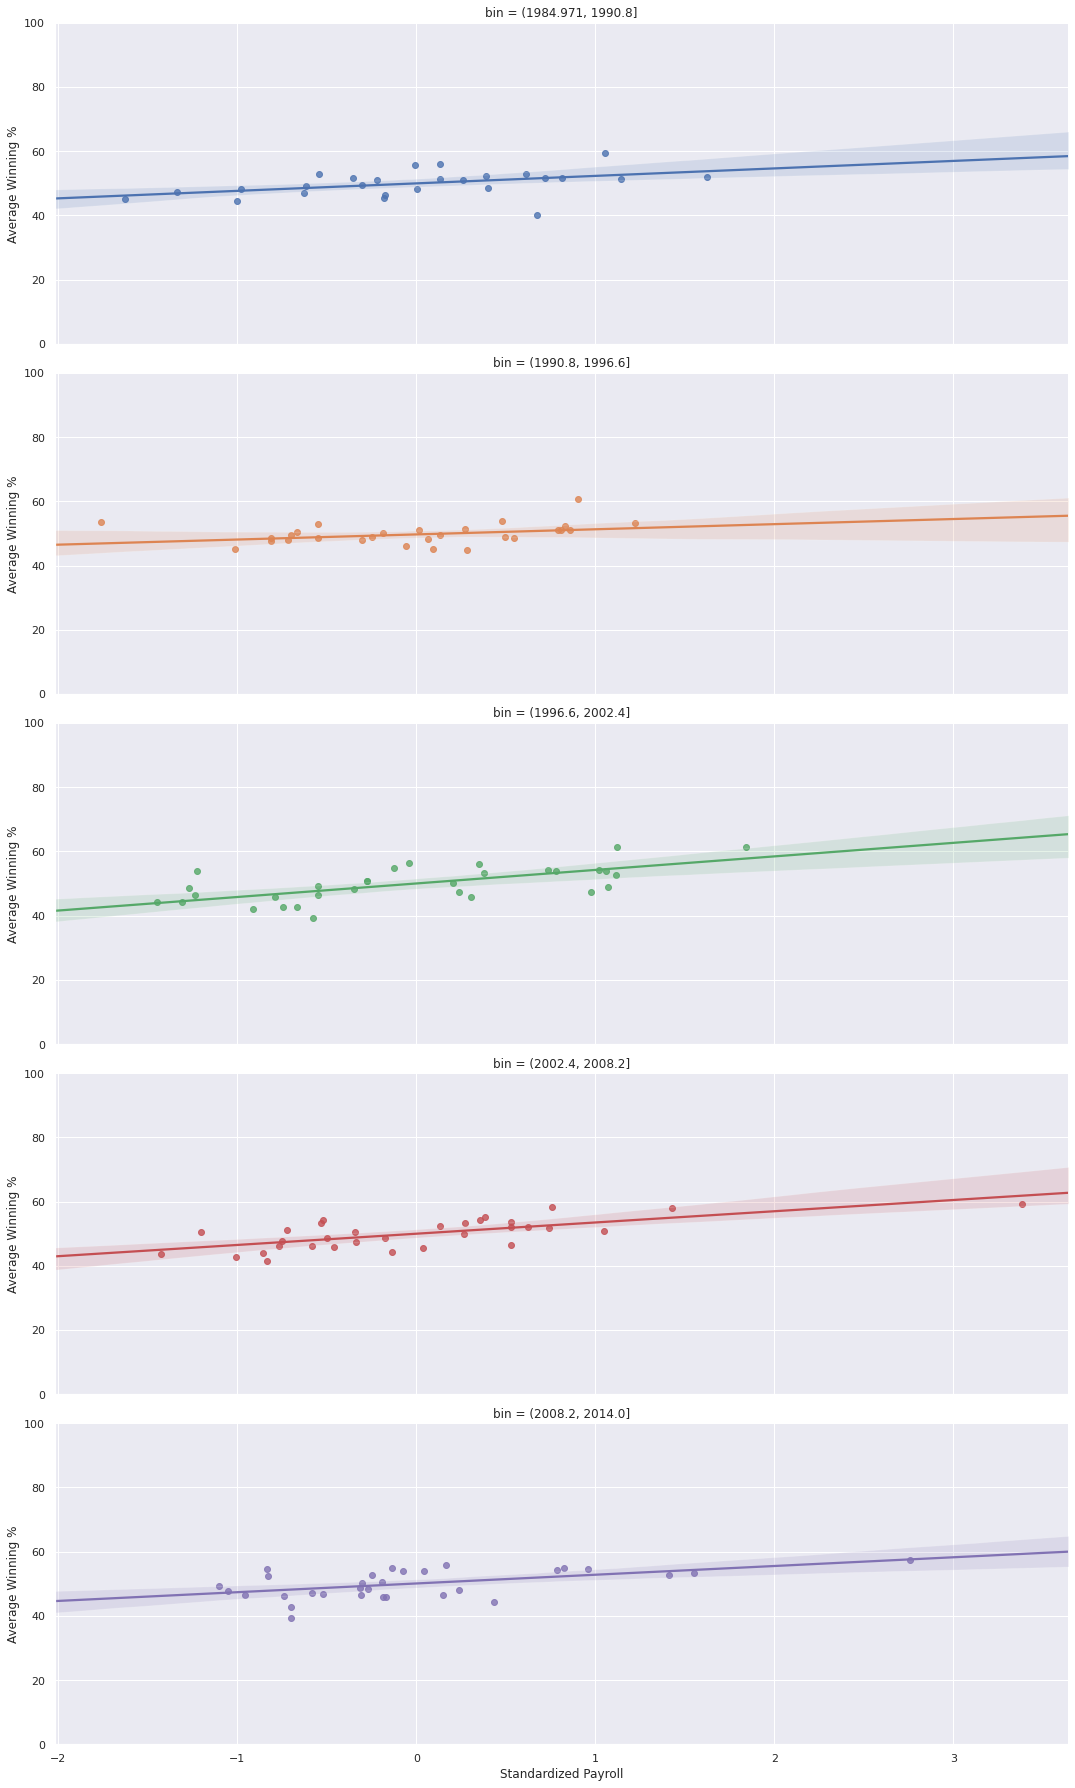

In [10]:
## Part 3
# Problem 6 - Repeat the same plots as Problem 4, but use this new standardized payroll variable.

team_aggregate_2 = team_aggregate.copy()
team_aggregate_2['bin'] = pd.cut(team_aggregate_2['yearID'], bins=5)

# Create dataframes using List Comprehension which splits groups into list of dataframes 
year_group = pd.DataFrame(team_aggregate_2.groupby(['bin', 'teamID'])['standardized_payroll','win_pct'].mean().dropna()).reset_index()

# Plot
g = sns.lmplot(x='standardized_payroll', y='win_pct', col='bin', hue='bin', data=year_group, logistic=False, truncate=False, robust=True, aspect=3, col_wrap=1)
g.set_axis_labels("Standardized Payroll", "Average Winning %")
g.set(ylim=(0, 100))

In [11]:
## Part 3
# Question 3 - Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable.

# The transformation I did on the payroll variable more accurately represents it in the relevant contexts.  One is, it can be more valuable to view the amount relative to other teams than the absolute value when comparing performance.  It also reduces the effects of inflation, which if not transformed, could convey misleading information.

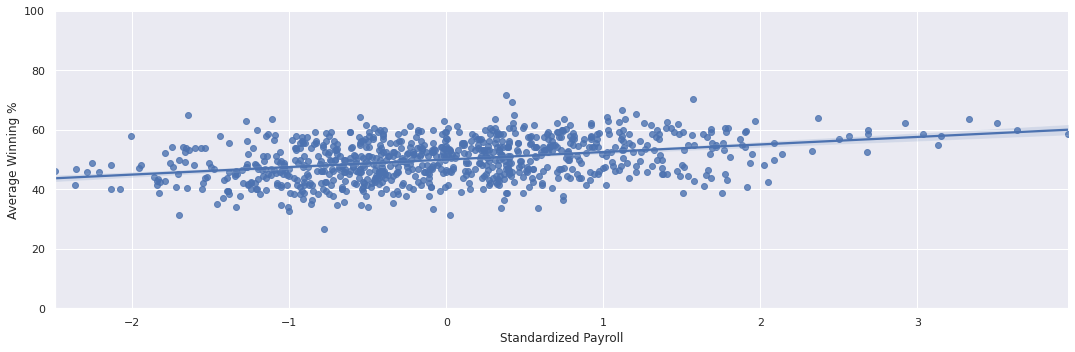

In [12]:
## Part 3
# Problem 7 - Expected wins
# Make a single scatter plot of winning percentage (y-axis) vs. standardized payroll (x-axis). Add a regression line to highlight the relationship.

g = sns.lmplot(x='standardized_payroll', y='win_pct', data=team_aggregate, aspect=3)
g.set_axis_labels("Standardized Payroll", "Average Winning %")
g.set(ylim=(0, 100))

In [13]:
# The regression line gives you expected winning percentage as a function of standardized payroll. Looking at the regression line, it looks like teams that spend roughly the average payroll in a given year will win 50% of their games (i.e. win_pct is 50 when standardized_payroll is 0), and teams increase 5% wins for every 2 standard units of payroll (i.e., win_pct is 55 when standardized_payroll is 2). We will see how this is done in general using linear regression later in the course.

# From these observations we can calculate the expected win percentage for team i in year j as
#   expected_win_pct = 50 + 2.5 * standardized_payroll

## Spending efficiency
# Using this result, we can now create a single plot that makes it easier to compare teams efficiency. The idea is to create a new measurement unit for each team based on their winning percentage and their expected winning percentage that we can plot across time summarizing how efficient each team is in their spending.

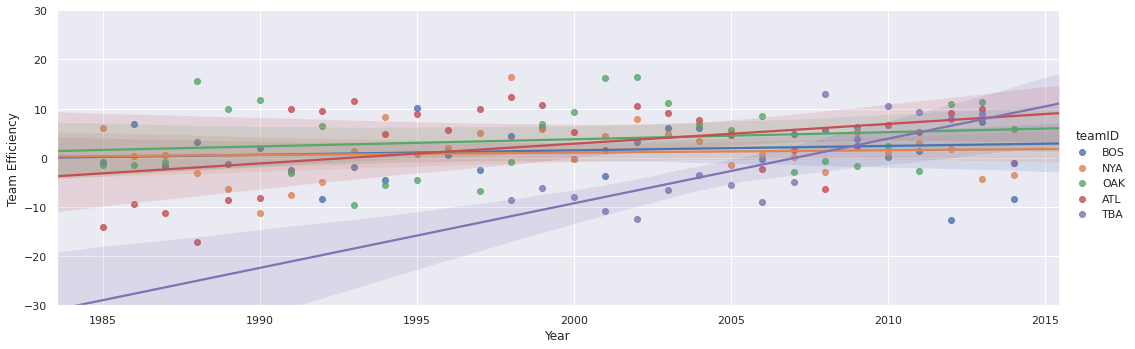

In [14]:
## Part 3
# Problem 8
# Create a new field to compute each team's spending effiency, given by
#   efficiency = win_pct - expected_win_pct
# for team i in year j, where expected_win_pct is given above.
# 
# Make a line plot with year on the x-axis and efficiency on the y-axis. A good set of teams to plot are Oakland, the New York Yankees, Boston, Atlanta and Tampa Bay (teamIDs OAK, BOS, NYA, ATL, TBA).

# curate teams
team_set = ['OAK', 'BOS', 'NYA', 'ATL', 'TBA']
curated_teams = team_aggregate[team_aggregate['teamID'].isin(team_set)].filter(['yearID', 'teamID', 'win_pct', 'standardized_payroll'])

# Predict win_pct
X = team_aggregate[['standardized_payroll']]
Y = team_aggregate[['win_pct']]
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)

# Add expected_win_pct, and efficiency columns to df
curated_teams['expected_win_pct'] = linear_regressor.predict(curated_teams[['standardized_payroll']])
curated_teams['efficiency'] = curated_teams['win_pct'] - curated_teams['expected_win_pct']

# Plot
g = sns.lmplot(x='yearID', y='efficiency', data=curated_teams, hue='teamID', logistic=False, truncate=False, robust=True, aspect=3)
g.set_axis_labels("Year", "Team Efficiency")
g.set(ylim=(-30, 30))

In [15]:
## Part 3
# Question 4 - What can you learn from this plot compared to the set of plots you looked at in Question 2 and 3? How good was Oakland's efficiency during the Moneyball period?

# This plot most accurately represents the data, because it is comparing efficiency rather than how much money a team spends on its players to how frequently it wins.  The difference between the two is that money spent does not capture the aspect of relativity to other teams.
# During the Moneyball period, Oakland's efficiency rose from sub-par levels of efficiency, to being the most efficient out of these other major teams.